# IS318 - Machine Learning

## TP3 - SVM and bag of features

In this TP, we will experiment with SVM classifiers. We will also work with K-Means clustering. We will apply these methods to a classical image classification approach called **bag of features**.

In [1]:
import sklearn
import sklearn.cluster
import sklearn.datasets
import sklearn.model_selection
import skimage.feature
import skimage.io
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

### 1. Introduction to SVM

In `scikit-learn` there exists several implementations of SVM. In this TP, we will use the `sklearn.svm.SVC` version, which allows to easily change the kernel used.

We will work a dataset of small images of faces called **Olivetti faces**. It is composed of 400 images of size 64x64, depicting 40 different persons.

In [2]:
olivetti_faces_dataset = sklearn.datasets.fetch_olivetti_faces()

**(Question)** Access the images and labels and set up an appropriate cross validation protocol.

*Hint*: take a look at the `sklearn.model_selection` module. 

In [3]:
X = olivetti_faces_dataset.images.reshape((-1, 4096)) 
y = olivetti_faces_dataset.target

def cross_validation(X, y, model, n_splits=5) :
    # Split the data into training and validation sets using cross-validation
    cross_val = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    res = []
    for train_idx, valid_idx in cross_val.split(X, y):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        res.append(accuracy_score(y_true=y_valid, y_pred=y_pred))
    return res



**(Question)** Train a multi-class linear SVM classifier on this dataset with your cross-validation protocol. Report the classification accuracy on the validation/test set(s).

In [4]:
# Splitting the dataset to a train dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initializing the svm model where kernel = linear
svm = SVC(kernel='linear')
accuracy_scores = cross_validation(X, y, svm)
print(f"Average accuracy score : {np.mean(accuracy_scores)}")

Average accuracy score : 0.975


**(Question)** Experiment with different hyperparameters (notably the soft margin parameter $C$) and different kernels. Compare the results.

In [5]:
# Different values for the C parameter
C = [0.001, 0.1, 1, 10, 100]
# Different values for the kernel parameter
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Printing the accuracy score for the different combination of the C and kernel values shown above
for c in C :
    for kernel in kernels :
        print(f'Average accuracy score for C = {c} and kernel = {kernel} : {np.mean(cross_validation(X, y, SVC(C=c, kernel=kernel)))}')

Average accuracy score for C = 0.001 and kernel = linear : 0.8125
Average accuracy score for C = 0.001 and kernel = poly : 0.74
Average accuracy score for C = 0.001 and kernel = rbf : 0.8575000000000002
Average accuracy score for C = 0.001 and kernel = sigmoid : 0.0
Average accuracy score for C = 0.1 and kernel = linear : 0.975
Average accuracy score for C = 0.1 and kernel = poly : 0.9649999999999999
Average accuracy score for C = 0.1 and kernel = rbf : 0.8575000000000002
Average accuracy score for C = 0.1 and kernel = sigmoid : 0.0
Average accuracy score for C = 1 and kernel = linear : 0.975
Average accuracy score for C = 1 and kernel = poly : 0.9649999999999999
Average accuracy score for C = 1 and kernel = rbf : 0.9425000000000001
Average accuracy score for C = 1 and kernel = sigmoid : 0.0
Average accuracy score for C = 10 and kernel = linear : 0.975
Average accuracy score for C = 10 and kernel = poly : 0.9649999999999999
Average accuracy score for C = 10 and kernel = rbf : 0.9650000

### 2. Scenes dataset

For the rest of the TP, to experiment with bag of features, we will work with the 8-scenes dataset originally from: https://people.csail.mit.edu/torralba/code/spatialenvelope/

It is provided as an archive file with this TP.

The function below can be used to load the dataset images and labels:

In [6]:
def load_scenes():
    '''Return images and labels of the scenes dataset.'''
    images = skimage.io.ImageCollection('scenes/*.jpg')
    labels_names = [f.split('/')[-1].split('_')[0] for f in images.files]
    unique_labels = sorted(list(set(labels_names)))
    labels_dict = {label: i + 1 for (i, label) in enumerate(unique_labels)}
    labels = np.array([labels_dict[label] for label in labels_names])
    return images, labels

**(Question)** Load the dataset and display some images of the different classes.

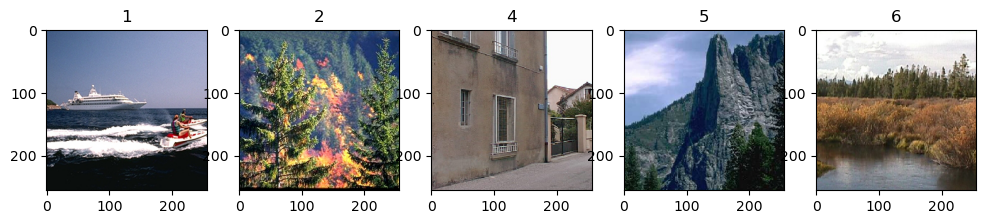

In [7]:
# Loading the images and labels
images, labels = load_scenes()

# Plotting some images that represent different classes
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i*500])
    plt.title(labels[i*500])
plt.show()

### 3. HOG features

Instead of working directly with image pixels (which would represent almost 200k dimensional features), we will be using a very popular image feature descriptor called the Histogram of Oriented Gradients (HOG).

The principle of HOG is to compute a feature vector on several subregions of the image (called patches) for example of size 8x8. The image is then represented as a set of feature vectors corresponding to all patches.

The feature vectors computed are histograms of gradient orientations: the gradient of the image is computed (corresponding to its changes of intensity in each pixel), then the orientations of this gradient in each patch are accumulated into bins (here, we will be using 9 bins per patch).

In computer vision, HOG features are heavily related with the other well-known SIFT keypoints.

In [8]:
def hog_features(image):
    # Return a list of HOG features for a given image
    features = skimage.feature.hog(image, pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                   block_norm='L2-Hys', feature_vector=False, #channel_axis=-1 
                                   )
    features = features.reshape(-1, features.shape[-1])
    return features

**(Question)** Compute HOG features for a single image. Take a look at the feature vectors obtained and try to understand what the dimensions correspond to.

In [9]:
# HOG features for the first image
features = hog_features(images[0]) 
print("HOG Features Shape :", features.shape)

HOG Features Shape : (1024, 9)


**(Question)** Compute HOG features for the whole dataset. If it takes too long, you can directly load them from the provided `hog.tgz` file.

In [10]:
# hog = []
# for image in images :
#     hog.append(hog_features(image))
# hog = np.array(hog)

# Loading the hog features
hog = np.load('hog.npy')
print(hog.shape)

(2686, 1024, 9)


**(Question)** Split these features into train and test sets (for example 75% train, 25% test).

*Hint*: you can use the `train_test_split` method from `sklearn.model_selection`.

In [11]:
# Train test split the hog data
hog_train, hog_test, y_train, y_test = train_test_split(hog, labels, test_size=0.25, random_state=42, shuffle=True)
# Reshaping the hog data to give to the Kmeans Model
features_train, features_test = hog_train.reshape((-1, hog_train.shape[2])), hog_test.reshape((-1, hog_test.shape[2]))

print(hog_train.shape)
print(features_train.shape)

(2014, 1024, 9)
(2062336, 9)


### 4. Bag of features

We will now implement the bag of features approach. It is composed on three main steps:
- Learn a vocabulary of visual words (also called codebook) using a clustering method (for example K-Means) applied on HOG features
- Project each feature of an image into the vocabulary, and build an histogram of these projections, giving a final single feature vector for the image
- Train an SVM classifier with these histograms of visual words as features for training images

**(Question)** Build the vocabulary of visual words with K-Means. The vocabulary size corresponds to the number of clusters.

In [12]:
def build_vocabulary(features, voc_size=100):
    # Cluster features into a visual vocabulary with K-Means algorithm,
    # then return the trained classified object.
    # You can use the MiniBatchKMeans class for very similar results 
    # but faster run time
    kmeans = KMeans(n_clusters=voc_size)
    kmeans.fit(features)
    return kmeans

In [13]:
# Build the vocabulary from train features
vocabulary = build_vocabulary(features_train, voc_size=100)

In [14]:
assert vocabulary.n_clusters == 100
assert vocabulary.n_features_in_ == 9

**(Question)** Try to understand the `build_codebook` function below. Then, compute the histograms of visual words for features of the train and test sets. Store the results into `X_train` and `X_test` variables.

In [23]:
def build_codebook(features, vocabulary):
    # Given a vocabulary of visual words (KMeans classifier object),
    # compute the codebook (histogram) of the set of features for an image
    voc_size = len(vocabulary.cluster_centers_)
    codebook = np.zeros((len(features), voc_size))
    for i, f in enumerate(features) :
        assignments = vocabulary.predict(f)
        for k in range(voc_size) :
            codebook[i][k] = len(np.where(assignments == k)[0])
    codebook = codebook / codebook.sum(axis=1)[:, np.newaxis] # normalization
    return codebook

In [24]:
# Build the codebooks for train and test features into X_train and X_test variables
X_train = build_codebook(hog_train, vocabulary)
X_test = build_codebook(hog_test, vocabulary)

In [25]:
assert X_train.shape == (y_train.shape[0], 100)
assert X_test.shape == (y_test.shape[0], 100)

**(Question)** Explain what the `build_codebook` function does.

**Answer :**

**The build_codebook function creates the visual word histogram (codebook) for a set of image features. To do this, it assigns each feature to one of the visual words in the vocabulary, then counts how many features in the same cluster for each cluster center k. Then, it normalizes the counts to create a visual word histogram, which serves as a feature vector for the image.**

**(Question)** Train an SVM classifier with the histograms of visual words and report the classification results. Analyze the results and try to improve the classification results by adjusting the hyperparameters.

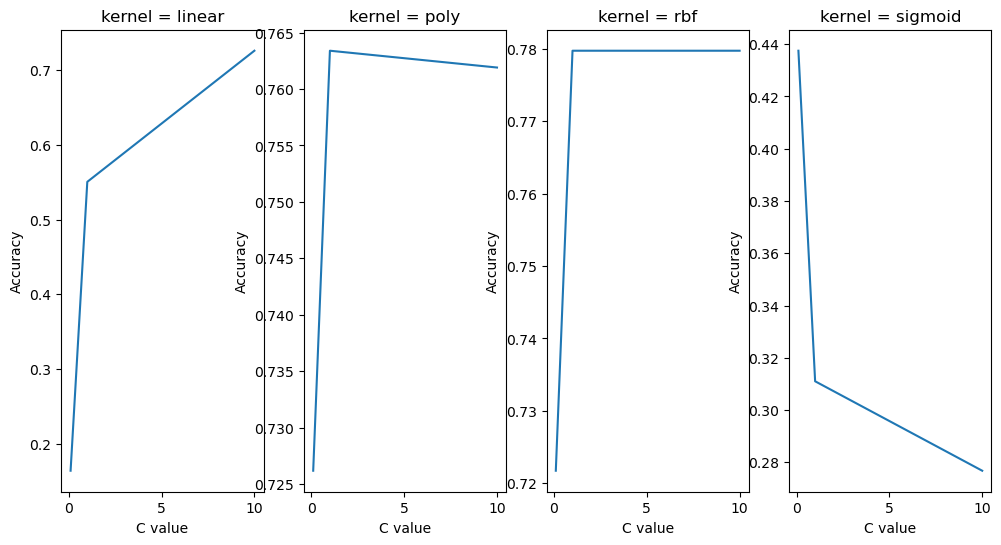

In [47]:
C = [0.1, 1, 10]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
plt.figure(figsize=(12, 6))
for i, kernel in enumerate(kernels) :
    accuracy = []
    for c in C :
        svm_classifier = SVC(kernel=kernel, C=c)
        svm_classifier.fit(X_train, y_train)
        accuracy.append(svm_classifier.score(X_test, y_test))
    plt.subplot(1, 4, i+1)
    plt.plot(C, accuracy)
    plt.xlabel("C value")
    plt.ylabel("Accuracy")
    plt.title(f'kernel = {kernel}')

In [26]:
# The gaussean kernel with default C = 1 gave the best result.
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)
accuracy = svm_classifier.score(X_test, y_test)
print("Classification Accuracy:", accuracy)

Classification Accuracy: 0.7797619047619048


**(Question)** Propose a visualization of some of the visual words learned by your bag of features model.

In [53]:
# centroids = vocabulary.cluster_centers_

# # Create a figure to display visual words
# plt.figure(figsize=(12, 12))

# for i in range(10):
#     plt.subplot(2, 5, i + 1)
#     visual_word = centroids[i]  # Reshape if your HOG features have 9 bins per patch
#     plt.hist(visual_word)

# plt.show()